<font size="+3">Time-series Generative Adversarial Network (TimeGAN)</font>

# Imports & Settings

Adapted from the excellent paper by Jinsung Yoon, Daniel Jarrett, and Mihaela van der Schaar:  
[Time-series Generative Adversarial Networks](https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks),  
Neural Information Processing Systems (NeurIPS), 2019.

- Last updated Date: April 24th 2020
- [Original code](https://bitbucket.org/mvdschaar/mlforhealthlabpub/src/master/alg/timegan/) author: Jinsung Yoon (jsyoon0823@gmail.com)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install tsaug
!pip install fredapi
!pip install sktime

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input, Dropout, BatchNormalization, LeakyReLU, Reshape, Conv1D, Flatten, Conv1DTranspose
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import AUC
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from sktime.utils.plotting import plot_series
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [4]:
sns.set_style('white')

# Experiment Path

In [5]:
results_path = Path('time_gan')
if not results_path.exists():
    results_path.mkdir()

In [6]:
experiment = 0

In [7]:
log_dir = results_path / f'experiment_{experiment:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

In [8]:
hdf_store = results_path / 'TimeSeriesGAN.h5'

# Prepare Data

In [9]:
#df=pd.read_csv(r'C:\Users\Kostas\Desktop\bitcoin.csv', index_col=('Date'), parse_dates=['Date'])
#df = df.drop('Currency', axis=1)
# df = df.resample('W').mean()
#df['Currency'] = 'USD'
#df['Volume'] = df['Volume'].astype(int)
#df['Year'] = df.index.strftime('%Y')
#df['Year'] = df['Year'].astype(int)
#df_forecast = df[(df['Year'] == 2021)]
#df = df[(df['Year'] > 2017) & (df['Year'] < 2023)]
#df = df.drop(["Open", "High", "Low", "Volume", "Currency", 'Year'], axis=1)
#df.tail()

In [10]:
fred = Fred(api_key='18ecafa4ff3f8087c46dd862605532f1')
data = fred.get_series('SP500')

In [11]:
df = pd.DataFrame({
    "WTI": fred.get_series("DCOILWTICO", observation_start="1987-05-20", observation_end="2020-12-31"),
    "BRENT": fred.get_series("DCOILBRENTEU", observation_start="1987-05-20", observation_end="2020-12-31")
})
df.head()

,WTI,BRENT
1987-05-20,19.75,18.63
1987-05-21,19.95,18.45
1987-05-22,19.68,18.55
1987-05-25,NaN,18.60
1987-05-26,19.35,18.63


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8772 entries, 1987-05-20 to 2020-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WTI     8475 non-null   float64
 1   BRENT   8536 non-null   float64
dtypes: float64(2)
memory usage: 205.6 KB


In [13]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8402 entries, 1987-05-20 to 2020-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WTI     8402 non-null   float64
 1   BRENT   8402 non-null   float64
dtypes: float64(2)
memory usage: 196.9 KB


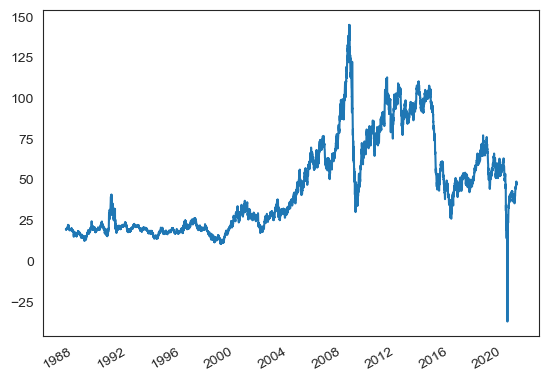

In [14]:
df['WTI'].plot();

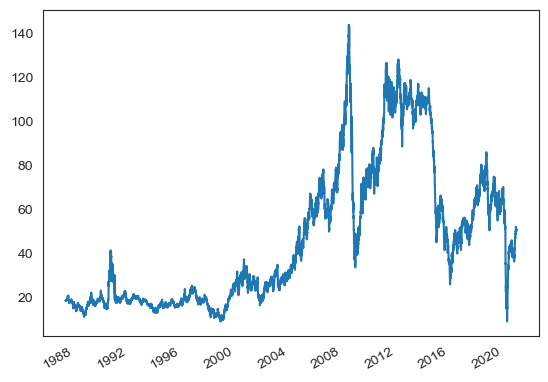

In [15]:
df['BRENT'].plot();

Text(0.5, 0, '')

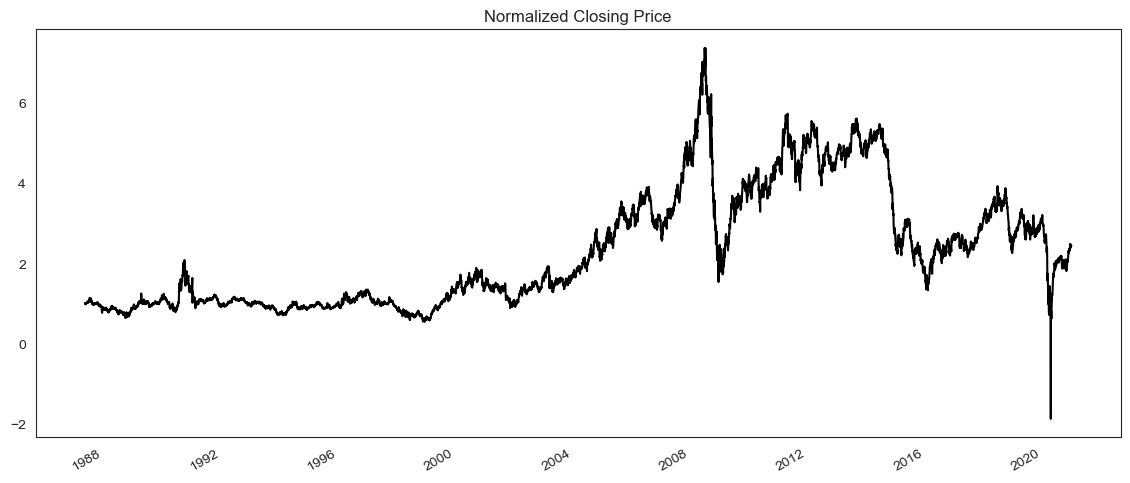

In [16]:
# Select the 'Close' column
close_col = df['WTI']

# Divide the 'Close' column by the first value in the column
normalized_close = close_col.div(close_col.iloc[0])

# Plot the normalized 'Close' column
ax = normalized_close.plot(figsize=(14, 6), title="Normalized Closing Price", legend=False, color='k')
ax.set_xlabel('')

## Plot Series

In [17]:
# Select only numeric columns
#numeric_cols = df.select_dtypes(include='number')

# Divide numeric columns by the first row
#normalized_df = numeric_cols.div(numeric_cols.iloc[0])

# Plot the normalized DataFrame
#axes = normalized_df.plot(subplots=True,
                           #figsize=(14, 6),
                           #layout=(3, 2),
                           #title="Closing Price",
                           #legend=False,
                           #rot=0,
                           #lw=1, 
                           #color='k')
#for ax in axes.flatten():
    #ax.set_xlabel('')

## Correlation

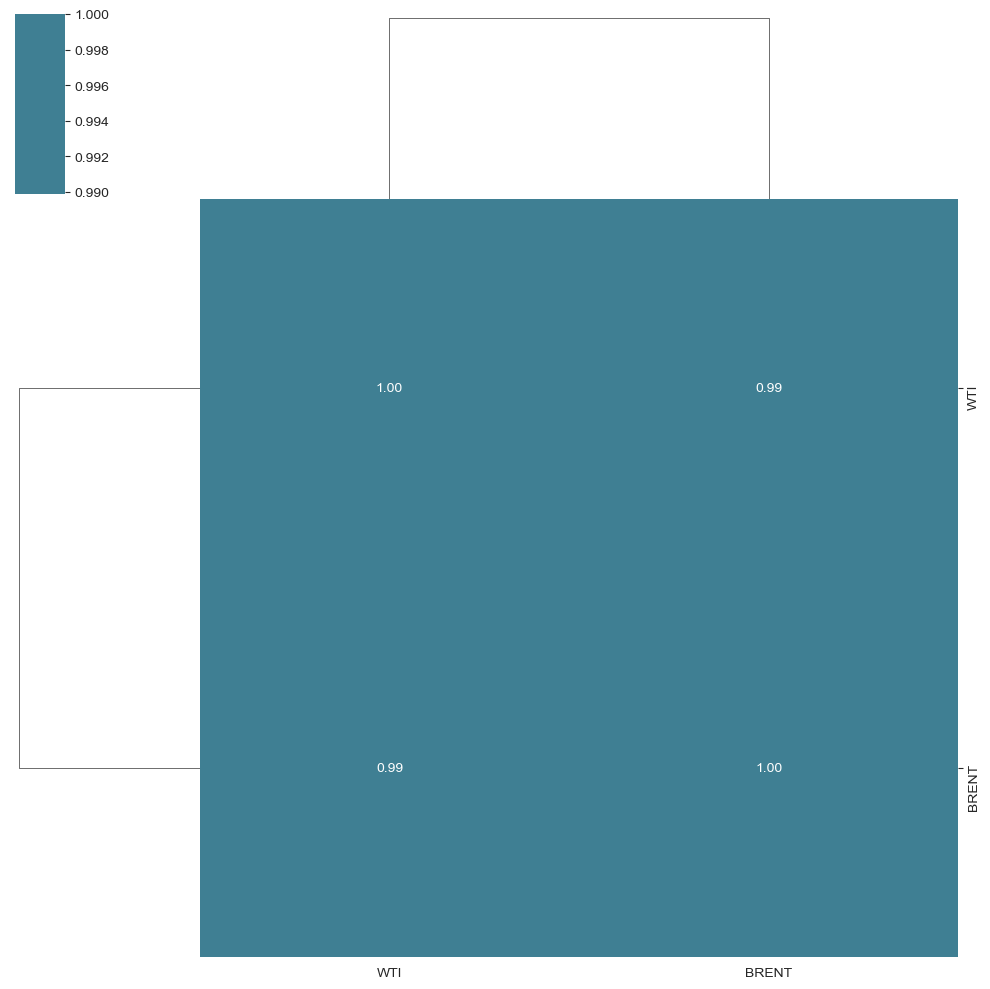

In [18]:
sns.clustermap(df.corr(),
               annot=True,
               fmt='.2f',
               cmap=sns.diverging_palette(h_neg=20,
                                          h_pos=220), center=0);

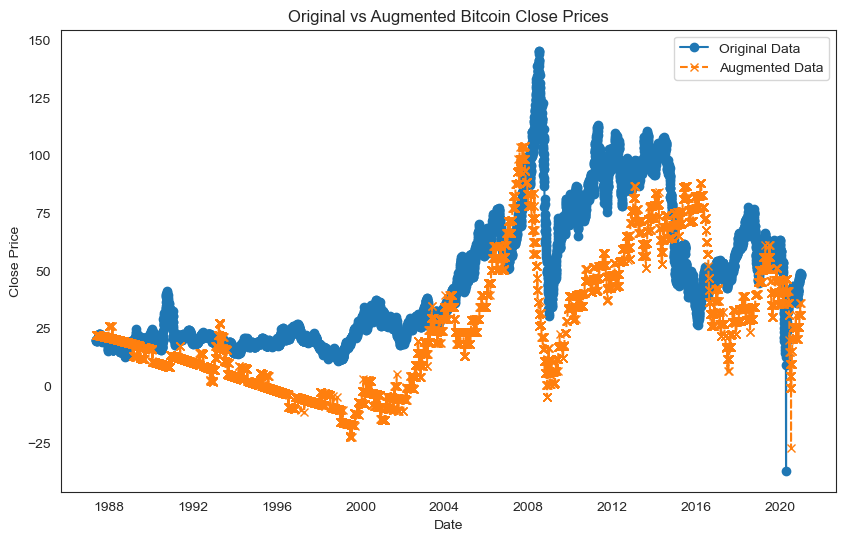

In [19]:
def augment_data(original_data, augmentations):
    augmented_data = original_data.copy()
    augmented_data['WTI'] = augmentations.augment(original_data['WTI'].values)
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['WTI'], label='Original Data', marker='o')
    plt.plot(augmented_data.index, augmented_data['WTI'], label='Augmented Data', linestyle='--', marker='x')
    plt.title('Original vs Augmented Bitcoin Close Prices')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()
    return augmented_data

augmenter = (
    TimeWarp()
    + Crop(size=8402)
    + Quantize(n_levels=[10, 20, 30])
    + Drift(max_drift=(0.1, 0.5))
    #+ Reverse()
)

augmented_data = augment_data(df, augmenter)

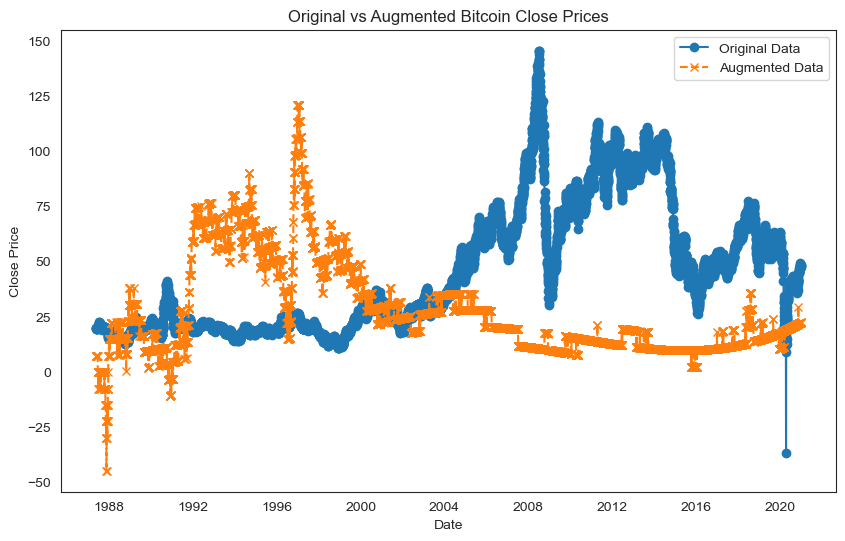

In [20]:
augmenter = (
    TimeWarp()
    + Crop(size=8402)
    + Quantize(n_levels=[10, 20, 30])
    + Drift(max_drift=(0.1, 0.5))
    + Reverse()
)

augmented_data = augment_data(df, augmenter)

## Normalize Data


Epoch 1/75

211/211 [==============================] - 8s 13ms/step - loss: 0.0128 - val_loss: 0.0121
Epoch 2/75
211/211 [==============================] - 2s 10ms/step - loss: 0.0056 - val_loss: 0.0049
Epoch 3/75
211/211 [==============================] - 2s 9ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 4/75
211/211 [==============================] - 2s 10ms/step - loss: 0.0022 - val_loss: 9.8062e-04
Epoch 5/75
211/211 [==============================] - 2s 10ms/step - loss: 0.0016 - val_loss: 3.9986e-04
Epoch 6/75
211/211 [==============================] - 2s 10ms/step - loss: 0.0013 - val_loss: 3.5909e-04
Epoch 7/75
211/211 [==============================] - 2s 9ms/step - loss: 0.0013 - val_loss: 1.9248e-04
Epoch 8/75
211/211 [==============================] - 2s 9ms/step - loss: 0.0011 - val_loss: 3.5050e-04
Epoch 9/75
211/211 [==============================] - 2s 10ms/step - loss: 9.5745e-04 - val_loss: 3.8464e-04
Epoch 10/75
211/211 [==============================] - 2s 9ms/st

211/211 [==============================] - 2s 9ms/step - loss: 4.1962e-04 - val_loss: 4.8834e-04
Epoch 73/75
211/211 [==============================] - 2s 10ms/step - loss: 3.9695e-04 - val_loss: 4.3560e-04
Epoch 74/75
211/211 [==============================] - 2s 10ms/step - loss: 3.7629e-04 - val_loss: 2.1941e-04
Epoch 75/75
263/263 [==============================] - 2s 4ms/step


KeyError: 'Synthetic Close'

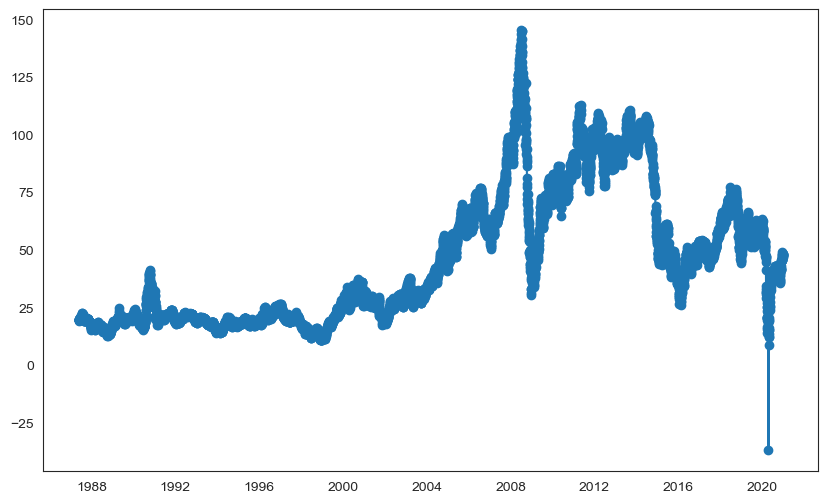

In [22]:
columns_for_autoencoder = ['WTI', 'BRENT']
scaler = MinMaxScaler()
original_data_scaled = scaler.fit_transform(df[columns_for_autoencoder])


input_dim = len(columns_for_autoencoder)
encoding_dim = 80
timesteps = original_data_scaled.shape[0]

original_data_scaled = np.reshape(original_data_scaled, (timesteps, input_dim, 1))

autoencoder = Sequential()

# Encoder
autoencoder.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(input_dim, 1)))
autoencoder.add(BatchNormalization())
autoencoder.add(Dropout(0.2))

autoencoder.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(BatchNormalization())
autoencoder.add(Dropout(0.2))

autoencoder.add(Flatten())
autoencoder.add(Dense(encoding_dim, activation='relu'))

# Decoder
autoencoder.add(Dense(32 * input_dim, activation='relu'))
autoencoder.add(Reshape((input_dim, 32)))

autoencoder.add(Conv1DTranspose(filters=64, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(BatchNormalization())
autoencoder.add(Dropout(0.2))

autoencoder.add(Conv1DTranspose(filters=1, kernel_size=3, activation='sigmoid', padding='same'))

original_data_scaled = np.reshape(original_data_scaled, (timesteps, input_dim))

autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

autoencoder.fit(original_data_scaled, original_data_scaled, epochs=75, batch_size=32, shuffle=True, validation_split=0.2)

synthetic_data_scaled = autoencoder.predict(original_data_scaled)
synthetic_data = pd.DataFrame(data=scaler.inverse_transform(synthetic_data_scaled.reshape(timesteps, input_dim)), index=df.index, columns=columns_for_autoencoder)

synthetic_data = np.maximum(synthetic_data, 0)

table = pd.concat([df[columns_for_autoencoder], synthetic_data.rename(columns=lambda x: 'Synthetic ' + x)], axis=1)

plt.figure(figsize=(10, 6))
plt.plot(table['WTI'], label='Original Close', marker='o')
plt.plot(table['Synthetic Close'], label='Synthetic Close', marker='o')
plt.title('Original vs Synthetic Close')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

# Time Gan

## Parameters

In [23]:
seq_len = 24
n_seq = 2
batch_size = 128

## Create rolling window sequences

In [24]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)

data = []
for i in range(len(df) - seq_len):
    data.append(scaled_data[i:i + seq_len])

n_windows = len(data)

In [25]:
scaled_data

array([[0.3112074 , 0.07067112],
       [0.31230456, 0.0693363 ],
       [0.3108234 , 0.07007787],
       ...,
       [0.4653574 , 0.30656284],
       [0.46749684, 0.30878755],
       [0.46810028, 0.31234705]], dtype=float32)

## Create tf.data.Dataset

In [26]:
real_series = (tf.data.Dataset
               .from_tensor_slices(data)
               .shuffle(buffer_size=n_windows)
               .batch(batch_size))
real_series_iter = iter(real_series.repeat())

In [27]:
# !pip install optuna-integration
# !pip install optuna
# import optuna
# from optuna.integration import TFKerasPruningCallback
# from tensorflow.keras.callbacks import EarlyStopping

# def objective(trial):
#     hidden_dim = trial.suggest_int('hidden_dim', 16, 128)
#     num_layers = trial.suggest_int('num_layers', 1, 4)
#     seq_len = trial.suggest_int('seq_len', 24, 128)
#     batch_size = trial.suggest_int('batch_size', 32, 256)
#     learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
#     train_steps = trial.suggest_int('train_steps', 500, 5000)

#     def make_rnn(n_layers, hidden_units, output_units, name):
#         return Sequential([GRU(units=hidden_units,
#                                return_sequences=True,
#                                name=f'GRU_{i + 1}') for i in range(n_layers)] +
#                           [Dense(units=output_units,
#                                  activation='sigmoid',
#                                  name='OUT')], name=name)

#     embedder = make_rnn(n_layers=num_layers, hidden_units=hidden_dim, output_units=hidden_dim, name='Embedder')
#     recovery = make_rnn(n_layers=num_layers, hidden_units=hidden_dim, output_units=n_seq, name='Recovery')
#     generator = make_rnn(n_layers=num_layers, hidden_units=hidden_dim, output_units=hidden_dim, name='Generator')
#     discriminator = make_rnn(n_layers=num_layers, hidden_units=hidden_dim, output_units=1, name='Discriminator')
#     supervisor = make_rnn(n_layers=num_layers-1, hidden_units=hidden_dim, output_units=hidden_dim, name='Supervisor')

#     autoencoder = Model(inputs=X, outputs=X_tilde, name='Autoencoder')
#     autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

#     early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#     pruning_callback = TFKerasPruningCallback(trial, 'val_loss')

#     history = autoencoder.fit(original_data_scaled, original_data_scaled, epochs=75, batch_size=batch_size,
#                               validation_split=0.2, callbacks=[early_stopping, pruning_callback], verbose=0)

#     val_loss = min(history.history['val_loss'])
#     return val_loss

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)

# print("Best hyperparameters: ", study.best_params)

# best_params = study.best_params
# hidden_dim = best_params['hidden_dim']
# num_layers = best_params['num_layers']
# seq_len = best_params['seq_len']
# batch_size = best_params['batch_size']
# learning_rate = best_params['learning_rate']
# train_steps = best_params['train_steps']

In [28]:
# # Print the parameters
# print(f"Hidden Dimension: {hidden_dim}")
# print(f"Number of Layers: {num_layers}")
# print(f"Sequence Length: {seq_len}")
# print(f"Batch Size: {batch_size}")
# print(f"Learning Rate: {learning_rate}")
# print(f"Training Steps: {train_steps}")

## Set up random series generator

In [29]:
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

We use the Python generator to feed a `tf.data.Dataset` that continues to call the random number generator as long as necessary and produces the desired batch size.

In [30]:
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

# TimeGAN Components

The design of the TimeGAN components follows the author's sample code.

##  Network Parameters

In [31]:
hidden_dim = 24
num_layers = 3

## Set up logger

In [32]:
writer = tf.summary.create_file_writer(log_dir.as_posix())

## Input place holders

In [33]:
X = Input(shape=[seq_len, n_seq], name='RealData')
Z = Input(shape=[seq_len, n_seq], name='RandomData')

## RNN block generator

We keep it very simple and use a very similar architecture for all four components. For a real-world application, they should be tailored to the data.

In [34]:
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units,
                           return_sequences=True,
                           name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

## Embedder & Recovery

In [35]:
embedder = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=hidden_dim, 
                    name='Embedder')
recovery = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=n_seq, 
                    name='Recovery')

## Generator & Discriminator

In [36]:
generator = make_rnn(n_layers=3, 
                     hidden_units=hidden_dim, 
                     output_units=hidden_dim, 
                     name='Generator')
discriminator = make_rnn(n_layers=3, 
                         hidden_units=hidden_dim, 
                         output_units=1, 
                         name='Discriminator')
supervisor = make_rnn(n_layers=2, 
                      hidden_units=hidden_dim, 
                      output_units=hidden_dim, 
                      name='Supervisor')

In [37]:
# Define the Encoder
def build_encoder(input_shape, latent_dim):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    model.add(layers.Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(latent_dim, activation=None))  # latent_dim is the size of the latent space
    return model

# Define the Decoder
def build_decoder(output_shape, latent_dim):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(latent_dim,)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(output_shape[0] * output_shape[1], activation='relu'))
    model.add(layers.Reshape((output_shape[0], output_shape[1])))
    model.add(layers.Conv1DTranspose(64, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(layers.Conv1DTranspose(1, kernel_size=5, strides=1, padding='same', activation='sigmoid'))
    return model

# Instantiate the encoder and decoder
input_shape = (seq_len, n_seq)
latent_dim = 20  # Example latent dimension, adjust as needed
encoder = build_encoder(input_shape, latent_dim)
decoder = build_decoder(input_shape, latent_dim)

# TimeGAN Training

## Settings

In [40]:
train_steps = 5000
gamma = 1

## Generic Loss Functions

In [41]:
mse = MeanSquaredError()
bce = BinaryCrossentropy()

# Phase 1: Autoencoder Training

## Architecture

In [42]:
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X,
                    outputs=X_tilde,
                    name='Autoencoder')

In [43]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 2)]           0         
                                                                 
 Embedder (Sequential)       (None, 24, 24)            9816      
                                                                 
 Recovery (Sequential)       (None, 24, 2)             10850     
                                                                 
Total params: 20666 (80.73 KB)
Trainable params: 20666 (80.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
plot_model(autoencoder,
           to_file=(results_path / 'autoencoder.png').as_posix(),
           show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Autoencoder Optimizer

In [45]:
autoencoder_optimizer = Adam()

## Autoencoder Training Step

In [48]:
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Autoencoder Training Loop

In [49]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

100%|██████████| 5000/5000 [02:38<00:00, 31.46it/s]


## Persist model

In [293]:
# autoencoder.save(log_dir / 'autoencoder')

# Phase 2: Supervised training

## Define Optimizer

In [50]:
supervisor_optimizer = Adam()

## Train Step

In [51]:
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, :-1, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

## Training Loop

In [52]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

100%|██████████| 5000/5000 [01:35<00:00, 52.59it/s]


## Persist Model

In [53]:
# supervisor.save(log_dir / 'supervisor')

# Joint Training

## Generator

### Adversarial Architecture - Supervised

In [54]:
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z,
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')

In [55]:
adversarial_supervised.summary()

Model: "AdversarialNetSupervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 2)]           0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            9816      
                                                                 
 Supervisor (Sequential)     (None, 24, 24)            7800      
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 28441 (111.10 KB)
Trainable params: 28441 (111.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [56]:
plot_model(adversarial_supervised, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Adversarial Architecture in Latent Space

In [57]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z,
                    outputs=Y_fake_e,
                    name='AdversarialNet')

In [58]:
adversarial_emb.summary()

Model: "AdversarialNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 2)]           0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            9816      
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 20641 (80.63 KB)
Trainable params: 20641 (80.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [59]:
plot_model(adversarial_emb, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Mean & Variance Loss

In [60]:
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z,
                       outputs=X_hat,
                       name='SyntheticData')

In [61]:
synthetic_data.summary()

Model: "SyntheticData"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 2)]           0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            9816      
                                                                 
 Supervisor (Sequential)     (None, 24, 24)            7800      
                                                                 
 Recovery (Sequential)       (None, 24, 2)             10850     
                                                                 
Total params: 28466 (111.20 KB)
Trainable params: 28466 (111.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
plot_model(synthetic_data, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [63]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

## Discriminator

### Architecture: Real Data

In [64]:
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name='DiscriminatorReal')

In [65]:
discriminator_model.summary()

Model: "DiscriminatorReal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 2)]           0         
                                                                 
 Embedder (Sequential)       (None, 24, 24)            9816      
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 20641 (80.63 KB)
Trainable params: 20641 (80.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [66]:
plot_model(discriminator_model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Optimizers

In [67]:
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

## Generator Train Step

In [68]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

## Embedding Train Step

In [69]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Discriminator Train Step

In [70]:
@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

In [71]:
@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

In [72]:
@tf.function
def train_encoder_decoder(real_data):
    with tf.GradientTape() as tape:
        encoded_data = encoder(real_data, training=True)
        reconstructed_data = decoder(encoded_data, training=True)
        reconstruction_loss = reconstruction_loss_fn(real_data, reconstructed_data)
    gradients = tape.gradient(reconstruction_loss, encoder.trainable_variables + decoder.trainable_variables)
    encoder_decoder_optimizer.apply_gradients(zip(gradients, encoder.trainable_variables + decoder.trainable_variables))
    return reconstruction_loss

## Training Loop

In [73]:
# step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
# for step in range(train_steps):
#     # Train generator (twice as often as discriminator)
#     for kk in range(2):
#         X_ = next(real_series_iter)
#         Z_ = next(random_series)

#         # Train generator
#         step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
#         # Train embedder
#         step_e_loss_t0 = train_embedder(X_)

#     X_ = next(real_series_iter)
#     Z_ = next(random_series)
#     step_d_loss = get_discriminator_loss(X_, Z_)
#     if step_d_loss > 0.15:
#         step_d_loss = train_discriminator(X_, Z_)

#     if step % 1000 == 0:
#         print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
#               f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

#     with writer.as_default():
#         tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
#         tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
#         tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
#         tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
#         tf.summary.scalar('D Loss', step_d_loss, step=step)

In [74]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = step_ed_loss = 0

# Define loss function and optimizer for the encoder-decoder training
reconstruction_loss_fn = tf.keras.losses.MeanSquaredError()
encoder_decoder_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)
        # Train encoder-decoder
        step_ed_loss = train_encoder_decoder(X_)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f} | '
              f'ed_loss: {step_ed_loss:6.4f}')

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)
        tf.summary.scalar('ED Loss', step_ed_loss, step=step)

     0 | d_loss: 1.9962 | g_loss_u: 0.7821 | g_loss_s: 0.0005 | g_loss_v: 0.2428 | e_loss_t0: 0.0616 | ed_loss: 0.0635
 1,000 | d_loss: 1.7820 | g_loss_u: 1.0554 | g_loss_s: 0.0000 | g_loss_v: 0.0133 | e_loss_t0: 0.0057 | ed_loss: 0.0093
 2,000 | d_loss: 1.9094 | g_loss_u: 1.1238 | g_loss_s: 0.0000 | g_loss_v: 0.0163 | e_loss_t0: 0.0043 | ed_loss: 0.0102
 3,000 | d_loss: 1.8878 | g_loss_u: 0.9531 | g_loss_s: 0.0000 | g_loss_v: 0.0215 | e_loss_t0: 0.0029 | ed_loss: 0.0095
 4,000 | d_loss: 1.8379 | g_loss_u: 1.1781 | g_loss_s: 0.0000 | g_loss_v: 0.0074 | e_loss_t0: 0.0026 | ed_loss: 0.0100


In [75]:
# Assuming scaled_data contains the entire dataset
data_sequences = []
for i in range(len(scaled_data) - seq_len):
    data_sequences.append(scaled_data[i:i + seq_len])
data_sequences = np.array(data_sequences)

data_sequences_reshaped = data_sequences.reshape(-1, seq_len, n_seq)

def detect_anomalies(data, encoder, decoder, threshold):
    encoded_data = encoder(data, training=False)
    reconstructed_data = decoder(encoded_data, training=False)
    reconstruction_error = tf.reduce_mean(tf.square(data - reconstructed_data), axis=[1, 2])
    anomalies = reconstruction_error > threshold
    return anomalies, reconstruction_error

threshold = 0.015  # Set an appropriate threshold based on validation data
anomalies, reconstruction_errors = detect_anomalies(data_sequences_reshaped, encoder, decoder, threshold)

## Persist Synthetic Data Generator

In [76]:
synthetic_data.save(log_dir / 'synthetic_data')

INFO:tensorflow:Assets written to: time_gan\experiment_00\synthetic_data\assets


INFO:tensorflow:Assets written to: time_gan\experiment_00\synthetic_data\assets


# Generate Synthetic Data

In [77]:
# generated_data_scaled = []
# for i in range(int(n_windows / batch_size)):
#     Z_ = next(random_series)
#     d = synthetic_data(Z_)
#     generated_data_scaled.append(d)

In [78]:
# def generate_and_filter_data(generator, encoder, decoder, random_series, batch_size, n_windows, threshold):
#     generated_data = []
#     for i in range(int(n_windows / batch_size)):
#         Z_ = next(random_series)
#         d = generator(Z_, training=False)
#         generated_data.append(d)
    
#     # Concatenate generated data into a single array
#     generated_data = np.concatenate(generated_data, axis=0)
    
#     improved_generated_data = []
#     for i in range(generated_data.shape[0]):
#         sample = generated_data[i:i+1]  # Extract a single sample
#         encoded_sample = encoder(tf.transpose(sample, [0, 2, 1]), training=False)  # Transpose sample
#         reconstructed_sample = decoder(encoded_sample, training=False)
#         reconstruction_error = tf.reduce_mean(tf.square(sample - reconstructed_sample))
        
#         # Filter out anomalies based on reconstruction error
#         if reconstruction_error < threshold:
#             improved_generated_data.append(sample)
    
#     # Convert the list of improved generated data to a numpy array
#     improved_generated_data = np.array(improved_generated_data)
    
#     return improved_generated_data, generated_data

# # Example usage
# threshold = 0.05  # Set an appropriate threshold based on validation data
# improved_generated_data, generated_data = generate_and_filter_data(generator, encoder, decoder, random_series, batch_size, n_windows, threshold)

In [79]:
generated_data_scaled = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data_scaled.append(d)

In [80]:
generated_data_scaled = np.array(np.vstack(generated_data_scaled))
generated_data_scaled.shape

(8320, 24, 2)

In [81]:
# def filter_data(generated_data_batches, encoder, decoder, threshold):
#     improved_generated_data = []
#     for batch in generated_data_batches:
#         for sample in batch:
#             encoded_sample = encoder(sample, training=False)
#             reconstructed_sample = decoder(encoded_sample, training=False)
#             reconstruction_error = tf.reduce_mean(tf.square(sample - reconstructed_sample))
#             # Filter out anomalies based on reconstruction error
#             if reconstruction_error < threshold:
#                 improved_generated_data.append(sample)
#     # Convert the list of improved generated data to a numpy array
#     improved_generated_data = np.array(improved_generated_data)
#     return improved_generated_data

In [82]:
def filter_data(generated_data_batches, encoder, decoder, threshold):
    improved_generated_data = []
    anomalous_data = []
    for batch in generated_data_batches:
        for sample in batch:
            # Ensure sample has the correct shape
            sample = tf.reshape(sample, [1, sample.shape[0], sample.shape[1]])  # Reshape to (1, 24, 1)
            
            # Encode and decode the sample
            encoded_sample = encoder(sample, training=False)
            reconstructed_sample = decoder(encoded_sample, training=False)
            
            # Calculate reconstruction error
            reconstruction_error = tf.reduce_mean(tf.square(sample - reconstructed_sample))
            
            # Filter out anomalies based on reconstruction error
            if reconstruction_error < threshold:
                improved_generated_data.append(sample)
            else:
                anomalous_data.append(sample)
                
    # Convert the list of improved generated data to a numpy array
    improved_generated_data = np.array(improved_generated_data)
    
    # Reshape back to original sample shape (24, 1)
    improved_generated_data = np.reshape(improved_generated_data, (-1, 24, 2))
    
    return improved_generated_data

# Example usage
threshold = 0.015  # Set an appropriate threshold based on validation data

# Assuming generated_data_scaled is a batch, so we need to convert it into a list of batches
generated_data_batches = [generated_data_scaled]

improved_generated_data = filter_data(generated_data_batches, encoder, decoder, threshold)
print(improved_generated_data.shape)

(5715, 24, 2)


In [336]:
# generated_data = generate_data(generator, random_series, batch_size, n_windows)

In [83]:
len(generated_data_scaled)

8320

In [84]:
# generated_data_scaled = np.array(np.vstack(generated_data_scaled))
# generated_data_scaled.shape

In [85]:
np.save(log_dir / 'generated_data.npy', generated_data_scaled)

## Rescale

In [86]:
generated_data = (scaler.inverse_transform(generated_data_scaled
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
print(generated_data.shape)
generated_ano_data = (scaler.inverse_transform(improved_generated_data
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
print(generated_ano_data.shape)

differences = generated_data != generated_ano_data
indices = np.where(differences)
print(indices)

(8320, 24, 2)
(5715, 24, 2)
(array([0], dtype=int64),)


## Persist Data

In [87]:
with pd.HDFStore(hdf_store) as store:
    store.put('data/synthetic', pd.DataFrame(generated_data.reshape(-1, n_seq),
                                             columns=['WTI','BRENT']))

## Plot sample Series

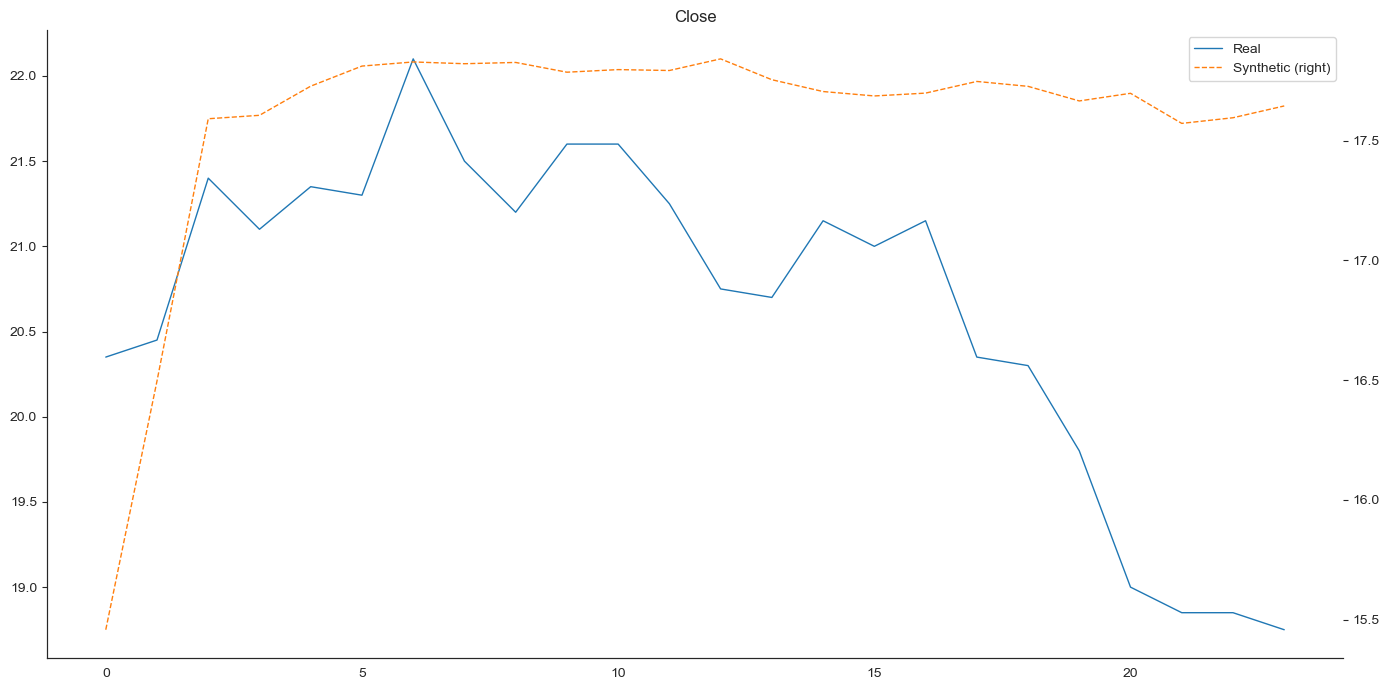

In [88]:
# Generate synthetic data for a random window
rand = np.random.randint(len(generated_data))
synthetic = generated_data[rand]

# Select a random real data window
idx = np.random.randint(len(df) - seq_len)
real = df.iloc[idx: idx + seq_len]

# Create a DataFrame with both real and synthetic data
data_to_plot = pd.DataFrame({
    'Real': real['WTI'].values,
    'Synthetic': synthetic[:, 0]  # Assuming synthetic data has the same shape
})

# Plotting
fig, ax = plt.subplots(figsize=(14, 7))
data_to_plot.plot(ax=ax, title='Close', secondary_y='Synthetic', style=['-', '--'], lw=1)
sns.despine()
fig.tight_layout()
plt.show()

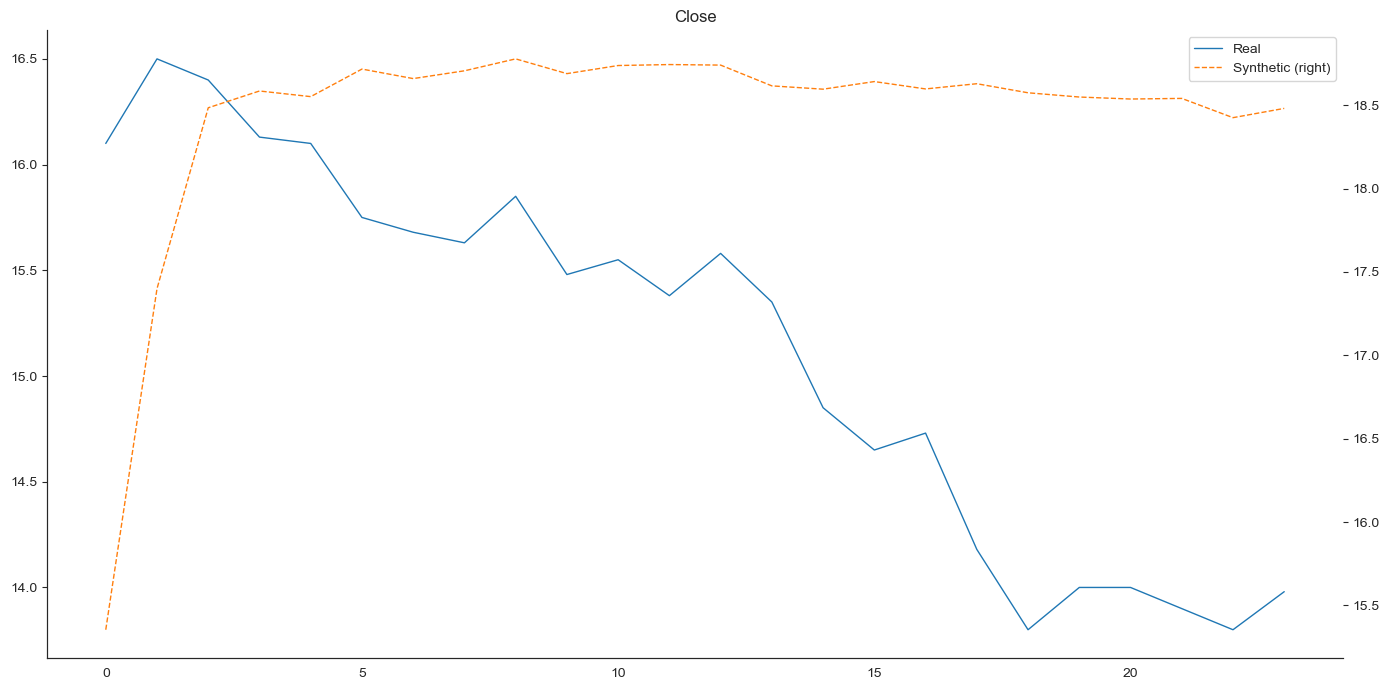

In [89]:
# Generate synthetic data for a random window
rand = np.random.randint(len(generated_data))
synthetic = generated_data[rand]

# Select a random real data window
idx = np.random.randint(len(df) - seq_len)
real = df.iloc[idx: idx + seq_len]

# Create a DataFrame with both real and synthetic data
data_to_plot = pd.DataFrame({
    'Real': real['BRENT'].values,
    'Synthetic': synthetic[:, 0]  # Assuming synthetic data has the same shape
})

# Plotting
fig, ax = plt.subplots(figsize=(14, 7))
data_to_plot.plot(ax=ax, title='Close', secondary_y='Synthetic', style=['-', '--'], lw=1)
sns.despine()
fig.tight_layout()
plt.show()

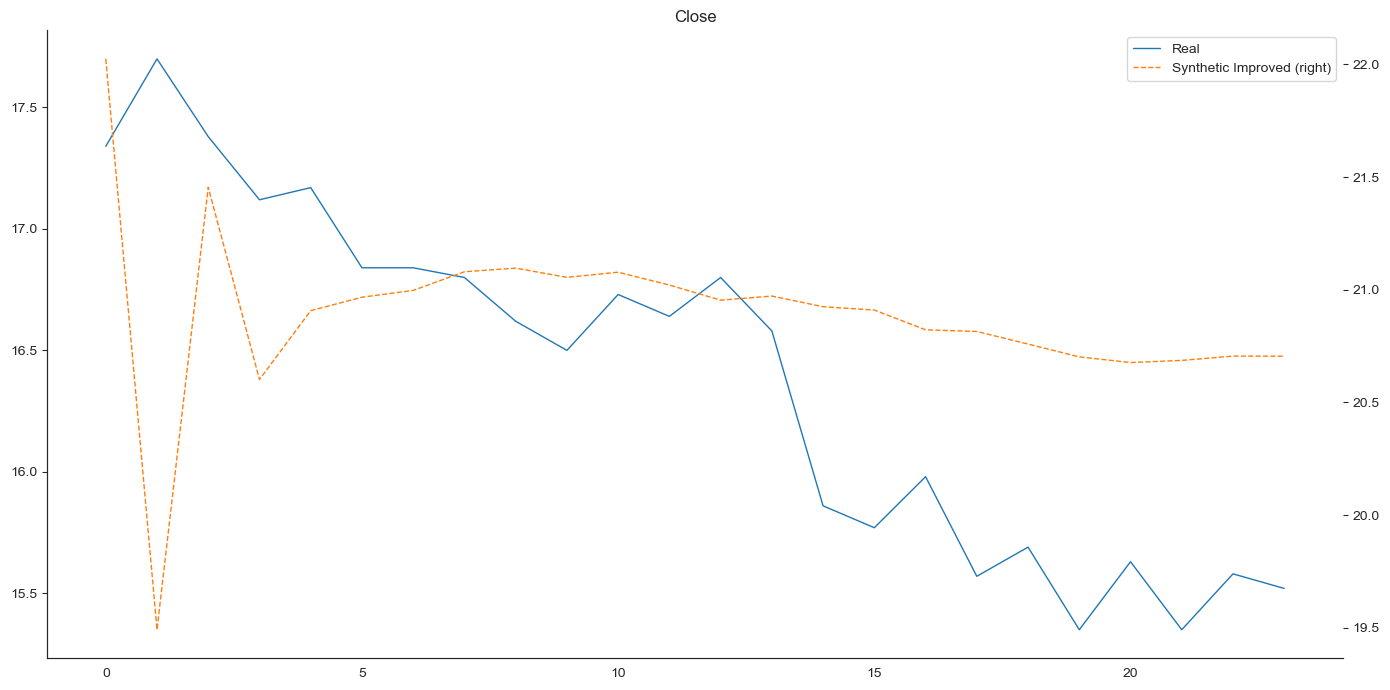

In [90]:
# Generate synthetic data for a random window
synthetic_ano_data = generated_ano_data[rand]

# Select a random real data window
# idx = np.random.randint(len(df) - seq_len)
real = df.iloc[idx: idx + seq_len]

# Create a DataFrame with both real and synthetic data
data_to_plot = pd.DataFrame({
    'Real': real['WTI'].values,
    'Synthetic Improved': synthetic_ano_data[:, 0]  # Assuming synthetic data has the same shape
})

# Plotting
fig, ax = plt.subplots(figsize=(14, 7))
data_to_plot.plot(ax=ax, title='Close', secondary_y='Synthetic Improved', style=['-', '--'], lw=1)
sns.despine()
fig.tight_layout()
plt.show()

In [91]:
experiment = 0

In [92]:
df.to_hdf(hdf_store, 'data/real')
df

,WTI,BRENT
1987-05-20,19.75,18.63
1987-05-21,19.95,18.45
1987-05-22,19.68,18.55
1987-05-26,19.35,18.63
1987-05-27,19.38,18.60
...,...,...
2020-12-24,48.18,50.88
2020-12-28,47.50,50.88
2020-12-29,47.85,50.44
2020-12-30,48.24,50.74


In [93]:
def get_real_data():
    df = pd.read_hdf(hdf_store, 'data/real').sort_index()

    # Preprocess the dataset:
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    data = []
    for i in range(len(df) - seq_len):
        data.append(scaled_data[i:i + seq_len])
    return data


real_data = get_real_data()

In [94]:
# def get_real_data():
#     preproc = df['Close'].values.reshape((243,1))

#     # Preprocess the dataset:
#     #scaler = MinMaxScaler()
#     #scaled_data = scaler.fit_transform(df)

#     data = []
#     for i in range(len(df) - seq_len):
#         data.append(preproc[i:i + seq_len])
#     return data


# real_data = get_real_data()

In [95]:
n = len(real_data)
n

8378

In [96]:
np.asarray(real_data).shape

(8378, 24, 2)

In [97]:
synthetic_data = improved_generated_data
synthetic_data.shape

(5715, 24, 2)

In [98]:
real_data = real_data[:synthetic_data.shape[0]]
len(real_data)

5715

In [99]:
sample_size = 250
idx = np.random.permutation(len(real_data))[:sample_size]

In [100]:
# Data preprocessing
real_sample = np.asarray(real_data)[idx]
synthetic_sample = np.asarray(synthetic_data)[idx]

In [101]:
real_sample_2d = real_sample.reshape(-1, seq_len)
synthetic_sample_2d = synthetic_sample.reshape(-1, seq_len)

In [102]:
real_sample_2d.shape, synthetic_sample_2d.shape

((500, 24), (500, 24))

In [103]:
# Assuming real_sample_2d and synthetic_sample_2d are defined

# Perform PCA
pca = PCA(n_components=2)
pca.fit(real_sample_2d)

# Transform the data and create DataFrames with an additional 'Data' column
pca_real = (pd.DataFrame(pca.transform(real_sample_2d))
            .assign(Data='Real'))
pca_synthetic = (pd.DataFrame(pca.transform(synthetic_sample_2d))
                 .assign(Data='Synthetic'))

# Concatenate the DataFrames and rename the columns
pca_result = pd.concat([pca_real, pca_synthetic]).rename(
    columns={0: '1st Component', 1: '2nd Component'})

print(pca_result)


     1st Component  2nd Component       Data
0        -0.522293       0.004494       Real
1        -0.553296       0.017931       Real
2         1.236161      -0.062171       Real
3         1.465784      -0.043996       Real
4        -0.503248      -0.003728       Real
..             ...            ...        ...
495       0.930994       0.002038  Synthetic
496      -0.159851       0.020118  Synthetic
497      -0.177812       0.008434  Synthetic
498      -0.384128       0.001666  Synthetic
499      -0.394580       0.004770  Synthetic

[1000 rows x 3 columns]


In [104]:
tsne_data = np.concatenate((real_sample_2d,
                            synthetic_sample_2d), axis=0)

tsne = TSNE(n_components=2,
            verbose=1,
            perplexity=200)
tsne_result = tsne.fit_transform(tsne_data)

[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.324s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.111329
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.211853
[t-SNE] KL divergence after 1000 iterations: 0.084654


In [105]:
tsne_result = pd.DataFrame(tsne_result, columns=['X', 'Y']).assign(Data='Real')
tsne_result.loc[sample_size*1.5:, 'Data'] = 'Synthetic'

In [106]:
pca_result

,1st Component,2nd Component,Data
0,-0.522293,0.004494,Real
1,-0.553296,0.017931,Real
2,1.236161,-0.062171,Real
3,1.465784,-0.043996,Real
4,-0.503248,-0.003728,Real
...,...,...,...
495,0.930994,0.002038,Synthetic
496,-0.159851,0.020118,Synthetic
497,-0.177812,0.008434,Synthetic
498,-0.384128,0.001666,Synthetic


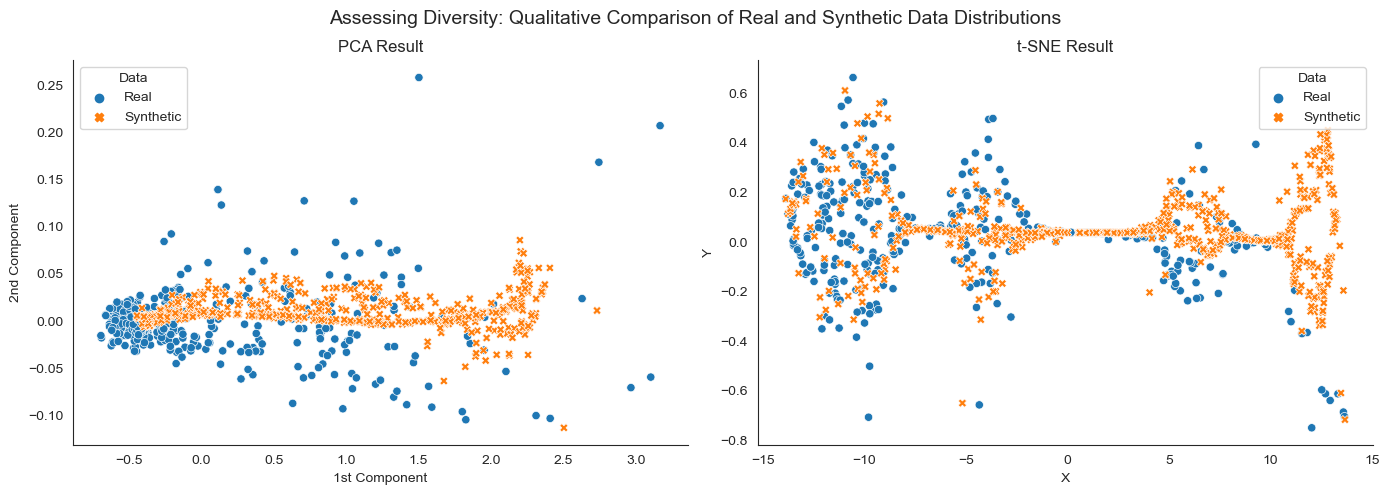

In [107]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

# PCA Result
sns.scatterplot(x='1st Component', y='2nd Component', data=pca_result,
                hue='Data', style='Data', ax=axes[0])
sns.despine()
axes[0].set_title('PCA Result')

# t-SNE Result
sns.scatterplot(x='X', y='Y', data=tsne_result,
                hue='Data', style='Data', ax=axes[1])
sns.despine()
axes[1].set_title('t-SNE Result')

# Set overall title and layout adjustments
fig.suptitle('Assessing Diversity: Qualitative Comparison of Real and Synthetic Data Distributions', 
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88)

# Show the plot
plt.show()

In [109]:
real_data = get_real_data()
real_data = np.array(real_data)[:len(synthetic_data)]

In [110]:
synthetic_data.shape

(5715, 24, 2)

In [111]:
n_series = real_data.shape[0]

In [112]:
idx = np.arange(n_series)

In [113]:
n_train = int(.8*n_series)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

In [114]:
train_data = np.vstack((real_data[train_idx], 
                        synthetic_data[train_idx]))
test_data = np.vstack((real_data[test_idx], 
                       synthetic_data[test_idx]))

In [115]:
n_train, n_test = len(train_idx), len(test_idx)
train_labels = np.concatenate((np.ones(n_train),
                               np.zeros(n_train)))
test_labels = np.concatenate((np.ones(n_test),
                              np.zeros(n_test)))

In [116]:
ts_classifier = Sequential([GRU(2, input_shape=(24, 2), name='GRU'),
                            Dense(1, activation='sigmoid', name='OUT')],
                           name='Time_Series_Classifier')

In [117]:
ts_classifier.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=[AUC(name='AUC'), 'accuracy'])

In [118]:
ts_classifier.summary()

Model: "Time_Series_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GRU (GRU)                   (None, 2)                 36        
                                                                 
 OUT (Dense)                 (None, 1)                 3         
                                                                 
Total params: 39 (156.00 Byte)
Trainable params: 39 (156.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [119]:
test_data

array([[[0.55603708, 0.40415276],
        [0.5583411 , 0.38976641],
        [0.5551045 , 0.39688543],
        ...,
        [0.54193867, 0.35669262],
        [0.54193867, 0.35736003],
        [0.53590433, 0.35528365]],

       [[0.5583411 , 0.38976641],
        [0.5551045 , 0.39688543],
        [0.5500576 , 0.38257323],
        ...,
        [0.54193867, 0.35736003],
        [0.53590433, 0.35528365],
        [0.55307477, 0.3633667 ]],

       [[0.5551045 , 0.39688543],
        [0.5500576 , 0.38257323],
        [0.54945417, 0.38717093],
        ...,
        [0.53590433, 0.35528365],
        [0.55307477, 0.3633667 ],
        [0.55466564, 0.37678902]],

       ...,

       [[0.63302416, 0.54292697],
        [0.63629776, 0.49750283],
        [0.63060802, 0.50530666],
        ...,
        [0.63317758, 0.51062804],
        [0.63345641, 0.51103067],
        [0.63332897, 0.51149487]],

       [[0.71462101, 0.70999658],
        [0.68087459, 0.77266806],
        [0.70427102, 0.76135558],
        .

In [120]:
# Now, train your model with the modified input data
result = ts_classifier.fit(x=train_data,
                            y=train_labels,
                            validation_data=(test_data, test_labels),
                            epochs=250,
                            batch_size=128,
                            verbose=0)

In [121]:
ts_classifier.evaluate(x=test_data, y=test_labels)

72/72 [==============================] - 0s 2ms/step - loss: 2.2372 - AUC: 0.3720 - accuracy: 0.3972  


[2.2371928691864014, 0.3720022737979889, 0.397200345993042]

In [122]:
history = pd.DataFrame(result.history)
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loss          250 non-null    float64
 1   AUC           250 non-null    float64
 2   accuracy      250 non-null    float64
 3   val_loss      250 non-null    float64
 4   val_AUC       250 non-null    float64
 5   val_accuracy  250 non-null    float64
dtypes: float64(6)
memory usage: 11.8 KB


In [123]:
from matplotlib.ticker import FuncFormatter

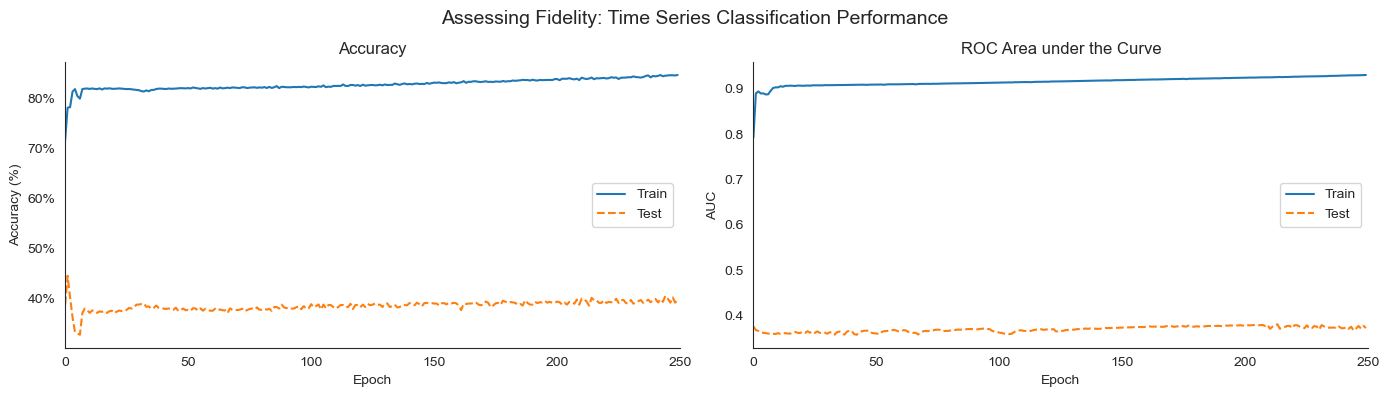

In [124]:
sns.set_style('white')
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
history[['AUC', 'val_AUC']].rename(columns={'AUC': 'Train', 'val_AUC': 'Test'}).plot(ax=axes[1], 
                                                                                     title='ROC Area under the Curve',
                                                                                    style=['-', '--'],
                                                                                    xlim=(0, 250))
history[['accuracy', 'val_accuracy']].rename(columns={'accuracy': 'Train', 'val_accuracy': 'Test'}).plot(ax=axes[0], 
                                                                                                         title='Accuracy',
                                                                                                        style=['-', '--'],
                                                                                                        xlim=(0, 250))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')

axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[0].set_ylabel('Accuracy (%)')
axes[1].set_ylabel('AUC')
sns.despine()
fig.suptitle('Assessing Fidelity: Time Series Classification Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

In [125]:
real_data = get_real_data()
real_data = np.array(real_data)[:len(synthetic_data)]

In [126]:
real_data.shape, synthetic_data.shape

((5715, 24, 2), (5715, 24, 2))

In [127]:
real_train_data = real_data[train_idx, :23, :]
real_train_label = real_data[train_idx, -1, :]

real_test_data = real_data[test_idx, :23, :]
real_test_label = real_data[test_idx, -1, :]

In [128]:
real_train_data.shape, real_train_label.shape, real_test_data.shape, real_test_label.shape

((4572, 23, 2), (4572, 2), (1143, 23, 2), (1143, 2))

In [129]:
synthetic_train = synthetic_data[:, :23, :]
synthetic_label = synthetic_data[:, -1, :]

In [130]:
synthetic_train.shape, synthetic_label.shape

((5715, 23, 2), (5715, 2))

In [144]:
# Option 1
def get_model():
    model = Sequential([GRU(12, input_shape=(seq_len-1, n_seq)),
                        Dense(2)])

    model.compile(optimizer=Adam(),
                  loss=MeanAbsoluteError(name='MAE'))
    return model

In [135]:
# Option 2
def get_model():
    model = Sequential()
    model.add(LSTM(50, input_shape=(23, 2), return_sequences=False))
    model.add(Dense(2))  # Output layer with 2 units to match the shape of the labels
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model

In [145]:
ts_regression = get_model()
real_result = ts_regression.fit(x=real_train_data,
                                y=real_train_label,
                                validation_data=(
                                    real_test_data, 
                                    real_test_label),
                                epochs=100,
                                batch_size=128,
                                verbose=0)

In [146]:
ts_regression = get_model()
synthetic_result = ts_regression.fit(x=synthetic_train,
                                     y=synthetic_label,
                                     validation_data=(
                                         real_test_data, 
                                         real_test_label),
                                     epochs=100,
                                     batch_size=128,
                                     verbose=0)

In [147]:
synthetic_result = pd.DataFrame(synthetic_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})
real_result = pd.DataFrame(real_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})

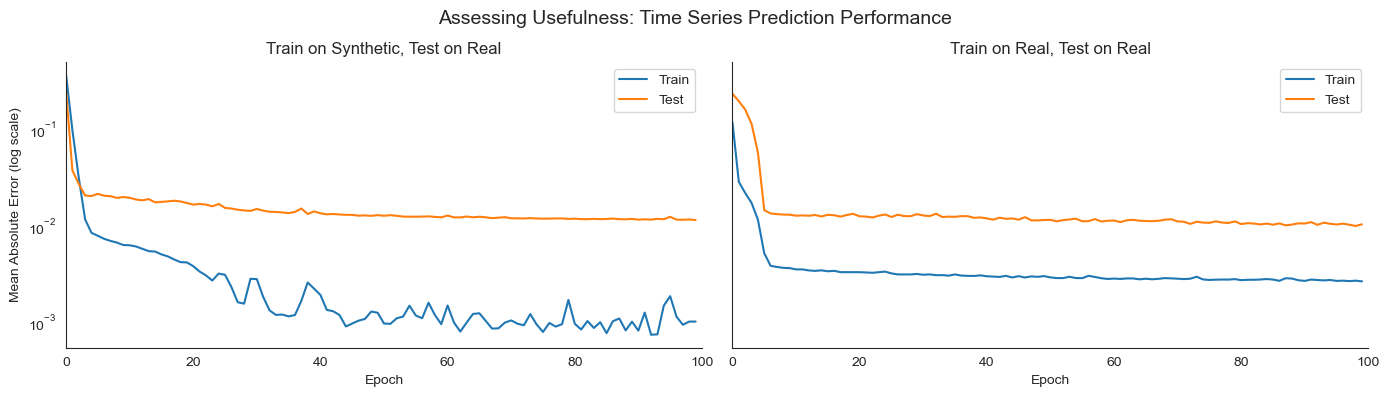

In [148]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)
synthetic_result.plot(ax=axes[0], title='Train on Synthetic, Test on Real', logy=True, xlim=(0, 100))
real_result.plot(ax=axes[1], title='Train on Real, Test on Real', logy=True, xlim=(0, 100))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Mean Absolute Error (log scale)')

sns.despine()
fig.suptitle('Assessing Usefulness: Time Series Prediction Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);